In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir -p /content/extracted_audioset

In [ ]:
# The features are stored in 12,228 TensorFlow record files,
# sharded by the first two characters of the YouTube video ID, and packaged as a tar.gz file.
!wget http://storage.googleapis.com/us_audioset/youtube_corpus/v1/features/features.tar.gz
!tar -xzvf features.tar.gz -C /content/extracted_audioset

流式输出内容被截断，只能显示最后 5000 行内容。
audioset_v1_embeddings/bal_train/M0.tfrecord
audioset_v1_embeddings/bal_train/Sb.tfrecord
audioset_v1_embeddings/bal_train/1r.tfrecord
audioset_v1_embeddings/bal_train/oB.tfrecord
audioset_v1_embeddings/bal_train/8P.tfrecord
audioset_v1_embeddings/bal_train/7u.tfrecord
audioset_v1_embeddings/bal_train/8p.tfrecord
audioset_v1_embeddings/bal_train/wO.tfrecord
audioset_v1_embeddings/bal_train/iq.tfrecord
audioset_v1_embeddings/bal_train/rT.tfrecord
audioset_v1_embeddings/bal_train/iz.tfrecord
audioset_v1_embeddings/bal_train/nJ.tfrecord
audioset_v1_embeddings/bal_train/4J.tfrecord
audioset_v1_embeddings/bal_train/DS.tfrecord
audioset_v1_embeddings/bal_train/wV.tfrecord
audioset_v1_embeddings/bal_train/em.tfrecord
audioset_v1_embeddings/bal_train/oJ.tfrecord
audioset_v1_embeddings/bal_train/Z4.tfrecord
audioset_v1_embeddings/bal_train/JQ.tfrecord
audioset_v1_embeddings/bal_train/73.tfrecord
audioset_v1_embeddings/bal_train/Ki.tfrecord
audioset_v1_embeddings/bal_t

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools

In [ ]:
def get_files(base_dir):
    tfrecord_files = []
    for subdir, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.tfrecord'):
                full_path = os.path.join(subdir, file)
                tfrecord_files.append(full_path)
    return tfrecord_files

In [ ]:
def extract_embeddings_and_labels(file_paths):
    embeddings = []
    labels = []

    for file_path in file_paths:
        dataset = tf.data.TFRecordDataset(file_path)
        for raw_record in dataset:
            context_parsed, sequence_parsed = tf.io.parse_single_sequence_example(
                raw_record,
                context_features={
                    'video_id': tf.io.FixedLenFeature([], tf.string),
                    'labels': tf.io.VarLenFeature(tf.int64),
                },
                sequence_features={
                    'audio_embedding': tf.io.FixedLenSequenceFeature([], dtype=tf.string),
                }
            )
            label_values = context_parsed['labels'].values.numpy()
            embedding_values = sequence_parsed['audio_embedding'].numpy()
            for emb in embedding_values:
                embeddings.append(emb)
                labels.append(label_values)

    return embeddings, labels

filter embeddings by label

In [ ]:
def filter_embeddings_by_label(embeddings, labels, target_label):
    filtered_embeddings = []
    for emb, lbls in zip(embeddings, labels):
        if target_label in lbls:
            filtered_embeddings.append(emb)
    return filtered_embeddings

In [ ]:
def bytes_to_float_array(byte_string):
    return np.frombuffer(byte_string, dtype=np.uint8).astype(np.float32)

In [ ]:
import itertools

def calculate_distances(embeddings):
    distances = []
    for emb1, emb2 in itertools.combinations(embeddings, 2):
        emb1_array = bytes_to_float_array(emb1)
        emb2_array = bytes_to_float_array(emb2)
        dist = np.linalg.norm(emb1_array - emb2_array)
        distances.append(dist)
    return distances


In [ ]:
import matplotlib.pyplot as plt

def plot_distance_distribution(distances):
    plt.figure(figsize=(10, 6))
    plt.hist(distances, bins=50, alpha=0.7)
    plt.title('Distribution of Euclidean Distances Between Embeddings')
    plt.xlabel('Euclidean Distance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()


In [ ]:
base_dir = '/content/extracted_audioset/audioset_v1_embeddings/bal_train'
file_paths = get_files(base_dir)
embeddings, labels = extract_embeddings_and_labels(file_paths)

In [ ]:
target_label = 73
filtered_embeddings = filter_embeddings_by_label(embeddings, labels, target_label)

In [ ]:
distances = calculate_distances(filtered_embeddings)

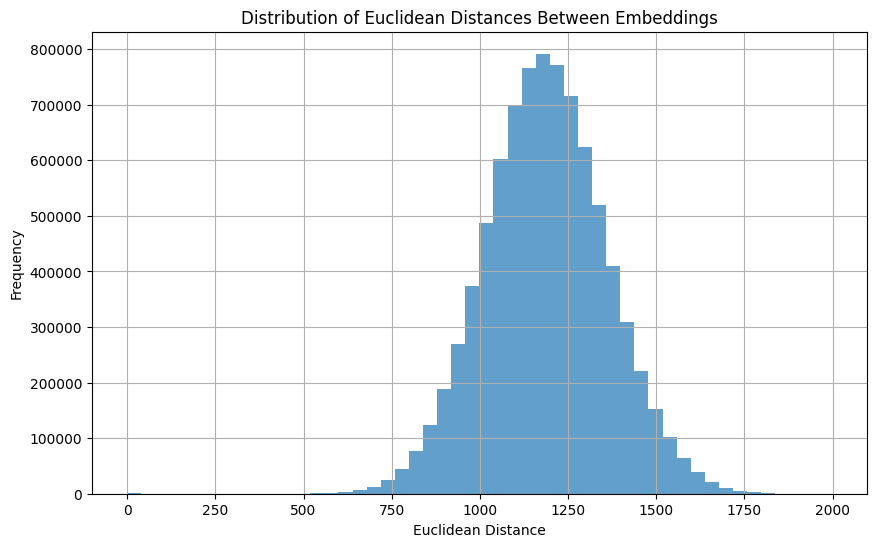

In [ ]:
plot_distance_distribution(distances)